# 1) Import Libraries 

In [3]:
import torch 
import torchvision
import torchvision.transforms as transforms 
import torch.optim as optim 
import torch.nn as nn 

import time 

## Check if using GPU 

In [4]:
print('GPU AVAILABLE: {}'.format(torch.cuda.is_available()))

GPU AVAILABLE: False


In [5]:
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

# 2) Loading Dataset

In [6]:
#Transform to a pytorch tensors and normalize our values between -1 and 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])

In [7]:
#Load our training data and specify what transform to use when loading 
train_set = torchvision.datasets.MNIST('mnist',
                                       train = True,
                                       download = True, 
                                       transform = transform)

#Load our test data and specify what transform to use when loading 
test_set = torchvision.datasets.MNIST('mnist',
                                     train = False, 
                                     download = True,
                                     transform = transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [8]:
print(train_set.data.shape)
print(test_set.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


# 3) Visualize Dataset

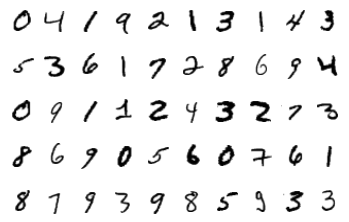

In [9]:
# Let's view the 50 first images of the MNIST training dataset
import matplotlib.pyplot as plt

figure = plt.figure()
num_of_images = 50 

for index in range(1, num_of_images + 1):
    plt.subplot(5, 10, index)
    plt.axis('off')
    plt.imshow(train_set.data[index], cmap='gray_r')

# 4) Preprocessing 

In [10]:
trainLoader = torch.utils.data.DataLoader(train_set, 
                                           batch_size = 128,
                                           shuffle = True, 
                                           num_workers = 0)

testLoader = torch.utils.data.DataLoader(test_set, 
                                         batch_size = 128,
                                         shuffle = False,
                                         num_workers = 0)

In [11]:
#Using iter() and Next() for loading batches 
#We use the python function iter() to return an iterator for our train_loader object 
dataiter = iter(trainLoader)

#we use next to get the fisrt batch of data from our iterator 
images, labels = next(dataiter)
print(images.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [12]:
images[0].shape

torch.Size([1, 28, 28])

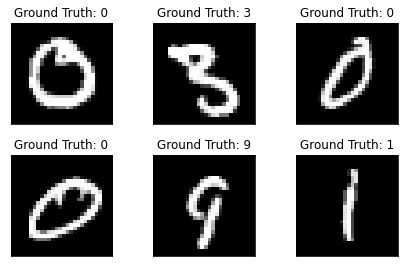

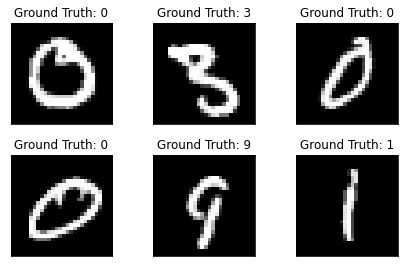

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(images[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(labels[i]))
  plt.xticks([])
  plt.yticks([])
fig

# 5) Building Convolutional Neural Network

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [15]:
import torch.optim as optim

#Loss Function 
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001)

# 6) Training The Model

In [16]:
epochs = 25

import time

start = time.time()

# Create some empty arrays to store logs 
epoch_log = []
loss_log = []
accuracy_log = []

# Iterate for a specified number of epochs
for epoch in range(epochs):  
    print(f'Starting Epoch: {epoch+1}...')

    # We keep adding or accumulating our loss after each mini-batch in running_loss
    running_loss = 0.0

    # We iterate through our trainloader iterator
    # Each cycle is a minibatch
    for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Move our data to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Clear the gradients before training by setting to zero
        # Required for a fresh start
        optimizer.zero_grad()

        # Forward -> backprop + optimize
        outputs = net(inputs) # Forward Propagation 
        loss = criterion(outputs, labels) # Get Loss (quantify the difference between the results and predictions)
        loss.backward() # Back propagate to obtain the new gradients for all nodes
        optimizer.step() # Update the gradients/weights

        # Print Training statistics - Epoch/Iterations/Loss/Accuracy
        running_loss += loss.item()
        if i % 50 == 49:    # show our loss every 50 mini-batches
            correct = 0 # Initialize our variable to hold the count for the correct predictions
            total = 0 # Initialize our variable to hold the count of the number of labels iterated

            # We don't need gradients for validation, so wrap in 
            # no_grad to save memory
            with torch.no_grad():
                # Iterate through the testloader iterator
                for data in testLoader:
                    images, labels = data
                    # Move our data to GPU
                    images = images.to(device)
                    labels = labels.to(device)
                    
                    # Foward propagate our test data batch through our model
                    outputs = net(images)

                     # Get predictions from the maximum value of the predicted output tensor
                     # we set dim = 1 as it specifies the number of dimensions to reduce
                    _, predicted = torch.max(outputs.data, dim = 1)
                    # Keep adding the label size or length to the total variable
                    total += labels.size(0)
                    # Keep a running total of the number of predictions predicted correctly
                    correct += (predicted == labels).sum().item()

                accuracy = 100 * correct / total
                epoch_num = epoch + 1
                actual_loss = running_loss / 50
                print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)}, Loss: {actual_loss:.3f}, Test Accuracy = {accuracy:.3f}%')
                running_loss = 0.0

    # Store training stats after each epoch
    epoch_log.append(epoch_num)
    loss_log.append(actual_loss)
    accuracy_log.append(accuracy)

print('Finished Training')
print("Total time: ", time.time() - start, "seconds") 

Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 50, Loss: 2.294, Test Accuracy = 11.390%
Epoch: 1, Mini-Batches Completed: 100, Loss: 2.278, Test Accuracy = 14.700%
Epoch: 1, Mini-Batches Completed: 150, Loss: 2.261, Test Accuracy = 18.830%
Epoch: 1, Mini-Batches Completed: 200, Loss: 2.245, Test Accuracy = 32.990%
Epoch: 1, Mini-Batches Completed: 250, Loss: 2.225, Test Accuracy = 35.310%
Epoch: 1, Mini-Batches Completed: 300, Loss: 2.207, Test Accuracy = 33.960%
Epoch: 1, Mini-Batches Completed: 350, Loss: 2.186, Test Accuracy = 45.940%
Epoch: 1, Mini-Batches Completed: 400, Loss: 2.163, Test Accuracy = 52.630%
Epoch: 1, Mini-Batches Completed: 450, Loss: 2.138, Test Accuracy = 56.880%
Starting Epoch: 2...
Epoch: 2, Mini-Batches Completed: 50, Loss: 2.094, Test Accuracy = 61.480%
Epoch: 2, Mini-Batches Completed: 100, Loss: 2.058, Test Accuracy = 62.030%
Epoch: 2, Mini-Batches Completed: 150, Loss: 2.014, Test Accuracy = 64.320%
Epoch: 2, Mini-Batches Completed: 200, Loss: 1.9

# 7) Plotting Training Logs 

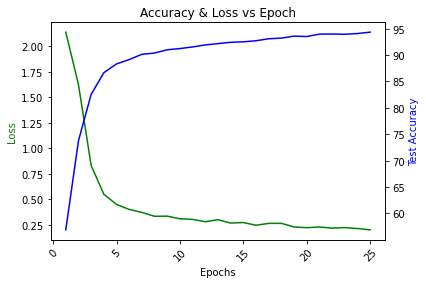

In [17]:
# To create a plot with secondary y-axis we need to create a subplot
fig, ax1 = plt.subplots()

# Set title and x-axis label rotation
plt.title("Accuracy & Loss vs Epoch")
plt.xticks(rotation=45)

# We use twinx to create a plot a secondary y axis
ax2 = ax1.twinx()

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, loss_log, 'g-')
ax2.plot(epoch_log, accuracy_log, 'b-')

# Set labels
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()

# 8) Plotting Confusion Matrix 

In [20]:
nb_classes = 10

confusion_matrix = torch.zeros(nb_classes, nb_classes)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(testLoader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns 

nb_classes = 10

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(testLoader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = net(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[[ 966    0    2    1    0    2    6    1    2    0]
 [   0 1115    3    2    0    1    4    1    9    0]
 [   9    1  968    8   11    0    8   10   12    5]
 [   2    1   19  945    0   10    2   12    7   12]
 [   1    2    3    0  931    0    9    3    2   31]
 [   9    2    3   31    4  798   15    5   14   11]
 [  11    3    4    0   10    6  921    1    2    0]
 [   2    6   25    4    5    0    0  961    1   24]
 [  11    4    6   18    9   11   10   10  882   13]
 [  10    6    1   11   18    5    1   16    3  938]]
[98.57142857 98.23788546 93.79844961 93.56435644 94.80651731 89.46188341
 96.13778706 93.48249027 90.55441478 92.96333003]
